In [1]:
from pathlib import Path
import numpy as np
import pysam
from tqdm import tqdm
from itertools import repeat
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly
import plotly.io as pio
import argparse
from random import seed,uniform


def view_modifications(bamfile_path:str, IVT_path:str, reference_path:str, literature_mod_df_path:str, condition:str):
    literature_mod_df = pd.read_csv(literature_mod_df_path ,sep="\t",header=None,index_col=None) #"~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed"
    literature_mod_df.columns = ["reference","start","end","modification","A","B","C"]

    psu_mod_df = literature_mod_df.loc[literature_mod_df["modification"] == "psu"]
    Um_mod_df = literature_mod_df.loc[literature_mod_df["modification"] == "Um"]
    
    A_mod_df = literature_mod_df.loc[literature_mod_df["modification"].isin(["Am","m62A","m6A"])]


    fasta_file = pysam.FastaFile(reference_path)
    reference = fasta_file.references[0]
    reference_sequence = str(fasta_file.fetch(reference))

    reads_aligning = [0 for i in range(len(reference_sequence))]
    mod_positions_m6a = [0 for i in range(len(reference_sequence))]
    mod_positions_pseU = [0 for i in range(len(reference_sequence))]
    number_of_basecalled_C = [0 for i in range(len(reference_sequence))]

    bamfile = pysam.AlignmentFile(bamfile_path, mode="rb")
    for i in tqdm(bamfile.fetch(until_eof=True)):
        if i.is_supplementary:
            continue
        start = i.reference_start
        end = i.reference_end
        for index in range(start,end):
            reads_aligning[index] += 1
        mod_obj = i.modified_bases
        if mod_obj != None:
            # try:
            #     mod_m6a = list(mod_obj[('A', 0, 'a')])
            # except KeyError:
            #     mod_m6a = None
            try:
                mod_pseU = list(mod_obj[('T', 0, 17802)])
            except KeyError:
                mod_pseU = None
            try:
                aligned_pairs = i.get_aligned_pairs(with_seq=True)
                alignment_dict = {}
                for pair_element in aligned_pairs:
                    if None not in pair_element:
                        alignment_dict[str(pair_element[0])] = {"index_query":pair_element[0],"index_reference":pair_element[1],"base_query": str(i.get_forward_sequence())[pair_element[0]],"base_reference": reference_sequence[pair_element[1]]}
                #if mod_m6a != None:
                #    for mod_base in mod_m6a:
                #        p = ((mod_base[1] + 1)/256)
                #        if p >= 0.95 and str(mod_base[0]) in alignment_dict:
                #            mod_positions_m6a[alignment_dict[str(mod_base[0])]["index_reference"]] += 1

                if mod_pseU != None:
                    for mod_base2 in mod_pseU:
                        p = ((mod_base2[1] + 1)/256)
                        if p >= 0.95 and str(mod_base2[0]) in alignment_dict:
                            mod_positions_pseU[alignment_dict[str(mod_base2[0])]["index_reference"]] += 1
                            
                for pair_element in aligned_pairs:
                    if None not in pair_element:
                        if alignment_dict[str(pair_element[0])]["base_query"] == "C" and alignment_dict[str(pair_element[0])]["base_reference"] == "T":
                            number_of_basecalled_C[pair_element[1]] += 1
            except TypeError:
                print("A type error occured")
    
    reads_aligning = np.array(reads_aligning)
    reads_aligning[reads_aligning == 0] = 1


    positions = [i+1 for i in range(len(reads_aligning))]

    mod_positions_m6a = np.array(mod_positions_m6a)
    rel_mod_positions_m6a = mod_positions_m6a/reads_aligning

    mod_positions_pseU = np.array(mod_positions_pseU)
    rel_mod_positions_pseU = mod_positions_pseU/reads_aligning

    number_of_basecalled_C = np.array(number_of_basecalled_C)
    rel_number_of_basecalled_C = number_of_basecalled_C/reads_aligning

    dataset = {
        "position":positions,
        "reads_aligning":reads_aligning,
        "n_pseU":mod_positions_pseU,
        "n_m6a":number_of_basecalled_C,
        "n_C":number_of_basecalled_C,
        "rel_n_pseU":rel_mod_positions_pseU,
        "rel_n_m6a":rel_mod_positions_m6a,
        "rel_n_C":rel_number_of_basecalled_C
    }

    modification_df = pd.DataFrame(dataset)
    modification_df.to_csv(f"{condition}_modification_quantification.csv",sep=";",header=True,index=None)
    
    IVT_reads_aligning = [0 for i in range(len(reference_sequence))]
    IVT_mod_positions_m6a = [0 for i in range(len(reference_sequence))]
    IVT_mod_positions_pseU = [0 for i in range(len(reference_sequence))]
    IVT_number_of_basecalled_C = [0 for i in range(len(reference_sequence))]
    

    IVT_bamfile = pysam.AlignmentFile(IVT_path, mode="rb")
    counter = 0
    for i in tqdm(IVT_bamfile.fetch(until_eof=True)):
        if counter >= 20000:
            break
        if i.is_supplementary:
            continue
        start = i.reference_start
        end = i.reference_end
        for index in range(start,end):
            IVT_reads_aligning[index] += 1
        mod_obj = i.modified_bases
        if mod_obj != None:
            # try:
            #     mod_m6a = list(mod_obj[('A', 0, 'a')])
            # except KeyError:
            #     mod_m6a = None
            try:
                mod_pseU = list(mod_obj[('T', 0, 17802)])
            except KeyError:
                mod_pseU = None
            aligned_pairs = i.get_aligned_pairs(with_seq=True)
            alignment_dict = {}
            for pair_element in aligned_pairs:
                if None not in pair_element:
                    alignment_dict[str(pair_element[0])] = {"index_query":pair_element[0],"index_reference":pair_element[1],"base_query": str(i.get_forward_sequence())[pair_element[0]],"base_reference": reference_sequence[pair_element[1]]}
            #if mod_m6a != None:
            #    for mod_base in mod_m6a:
            #        p = ((mod_base[1] + 1)/256)
            #        if p >= 0.95 and str(mod_base[0]) in alignment_dict:
            #            IVT_mod_positions_m6a[alignment_dict[str(mod_base[0])]["index_reference"]] += 1

            if mod_pseU != None:
                for mod_base2 in mod_pseU:
                    p = ((mod_base2[1] + 1)/256)
                    if p >= 0.95 and str(mod_base2[0]) in alignment_dict:
                        IVT_mod_positions_pseU[alignment_dict[str(mod_base2[0])]["index_reference"]] += 1
                        
            for pair_element in aligned_pairs:
                if None not in pair_element:
                    if alignment_dict[str(pair_element[0])]["base_query"] == "C" and alignment_dict[str(pair_element[0])]["base_reference"] == "T":
                        IVT_number_of_basecalled_C[pair_element[1]] += 1
        counter += 1

    IVT_reads_aligning = np.array(IVT_reads_aligning)
    IVT_reads_aligning[IVT_reads_aligning == 0] = 1


    IVT_positions = [i+1 for i in range(len(IVT_reads_aligning))]

    IVT_mod_positions_m6a = np.array(IVT_mod_positions_m6a)
    IVT_rel_mod_positions_m6a = IVT_mod_positions_m6a/IVT_reads_aligning

    IVT_mod_positions_pseU = np.array(IVT_mod_positions_pseU)
    IVT_rel_mod_positions_pseU = IVT_mod_positions_pseU/IVT_reads_aligning

    IVT_number_of_basecalled_C = np.array(IVT_number_of_basecalled_C)
    IVT_rel_number_of_basecalled_C = IVT_number_of_basecalled_C/IVT_reads_aligning
    
    IVT_dataset = {
        "position":IVT_positions,
        "reads_aligning":IVT_reads_aligning,
        "n_pseU":IVT_mod_positions_pseU,
        "n_m6a":IVT_number_of_basecalled_C,
        "n_C":IVT_number_of_basecalled_C,
        "rel_n_pseU":IVT_rel_mod_positions_pseU,
        "rel_n_m6a":IVT_rel_mod_positions_m6a,
        "rel_n_C":IVT_rel_number_of_basecalled_C
    }
    
    IVT_modification_df = pd.DataFrame(IVT_dataset)
    IVT_modification_df.to_csv(f"IVT_modification_quantification.csv",sep=";",header=True,index=None)

    

    layout = go.Layout(height = 800)
    fig = go.Figure(layout=layout)

    

    


    fig.add_trace(
            go.Scatter(
                x=[index for index in range(len(rel_number_of_basecalled_C))],
                y=[rel_mod_positions_pseU[index]+value for index,value in enumerate(rel_number_of_basecalled_C)],  # Use the same x position and y at the top of the line
                line_color="rgba(153,0,0,0.4)",
                showlegend=True,
                name="C/U + pseU freq."
            )
        )
    
    fig.add_trace(
        go.Scatter(
            x=[index for index in range(len(rel_mod_positions_pseU))],
            y=[value for index,value in enumerate(rel_mod_positions_pseU)],  # Use the same x position and y at the top of the line
            line_color="rgba(153,0,0,1)",
            showlegend=True,
            name="pseU freq."
        )
    )
    
    
    
    fig.add_trace(
            go.Scatter(
                x=[index for index in range(len(IVT_rel_number_of_basecalled_C))],
                y=[-IVT_rel_mod_positions_pseU[index]-value for index,value in enumerate(IVT_rel_number_of_basecalled_C)],  # Use the same x position and y at the top of the line
                line_color="rgba(0, 181, 204, 1)",
                showlegend=True,
                name="IVT 18S C/U + pseU freq."
            )
        )
    
    fig.add_trace(
            go.Scatter(
                x=[index for index in range(len(IVT_rel_mod_positions_pseU))],
                y=[-value for index,value in enumerate(IVT_rel_mod_positions_pseU)],   # Use the same x position and y at the top of the line
                line_color="rgba(30, 81, 123, 1)",
                showlegend=True,
                name="IVT 18S pseU freq."
            )
        )

    fig.add_trace(
        go.Scatter(
            x = [i for i in range(0,len(reference_sequence))],
            y = [0 for i in range(0,len(reference_sequence))],
            name= "",
            showlegend=False,
            line_color = "white"
            )
        )

    for index,T_position in psu_mod_df.iterrows():
        fig.add_shape(
            x0=T_position["end"]-1,
            x1=T_position["end"]-1,
            y0=0,
            y1=1,
            line=dict(
                color="rgba(90,34,139,0.5)",
                width=0.3,
                dash="dash"
                )
            )
    
    for index,T_position in Um_mod_df.iterrows():
        fig.add_shape(
            x0=T_position["end"]-1,
            x1=T_position["end"]-1,
            y0=0,
            y1=1,
            line=dict(
                color="rgba(4,59,92,0.5)",
                width=0.3,
                dash="dash"
                )
            )
    
    fig.add_trace(go.Scatter(
        x=[None], y=[None],  # Invisible point, used only for legend entry
        mode='lines',
        line=dict(
            color="rgba(255,106,106,0.5)",
            width=1,
            dash="dash"
        ),
        showlegend=True,
        name="known pseU"  # Legend entry name
    ))
    
    fig.add_trace(go.Scatter(
        x=[None], y=[None],  # Invisible point, used only for legend entry
        mode='lines',
        line=dict(
            color="rgba(4,59,92,0.7)",
            width=1,
            dash="dash"
        ),
        showlegend=True,
        name="known Um"  # Legend entry name
    ))
    
    

    fig.update_layout(
        title=f"Modification basecalling",
        xaxis=dict(title="Position on reference",gridcolor = "white",tickformat="d"),
        yaxis=dict(title="Modification frequency",gridcolor = "white"),
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.write_image(f"{condition}_general_modification_ratio_with_Um.svg",format="svg")
    fig.show()
    
    #5s
    fig.update_layout(
        xaxis=dict(range=[6550,6800])
    )
    fig.write_image(f"{condition}_5-8S_modification_ratio_with_Um.svg",format="svg")
    fig.show()
    
    
    #18S
    fig.update_layout(
        xaxis=dict(range=[3655,5620])
    )
    fig.write_image(f"{condition}_18S_modification_ratio_with_Um.svg",format="svg")
    fig.show()
    
    #28S
    fig.update_layout(
        xaxis=dict(range=[7910,13000])
    )
    fig.write_image(f"{condition}_28S_modification_ratio_with_Um.svg",format="svg")
    fig.show()
    

    

In [4]:
from pathlib import Path
import numpy as np
import pysam
from tqdm import tqdm
from itertools import repeat
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly
import plotly.io as pio
import argparse
from random import seed,uniform
def view_modification_per_fragment(bamfile_path:str, fragment_df_path:str,fragment_to_analyse: str,color:str,markerstyle:str, reference_path:str, literature_mod_df_path:str, condition:str, fig, ax):
    fragment_df = pl.read_csv(fragment_df_path, separator=";",has_header=True,columns=["Reference","Start","End","Fragment","Length","IDS","n_Reads","rel_n_Reads"])
    #print(fragment_df)
    fragment_df = fragment_df.to_pandas()
    fragment_df = fragment_df[fragment_df["Fragment"] == fragment_to_analyse]
    #print(fragment_df)
    fragment_ids = fragment_df["IDS"].to_list()[0]
    IDS_of_interest = eval(fragment_ids)
    #print(IDS_of_interest[0])
    dict_IDS_of_interest = {}
    for id in IDS_of_interest:
        dict_IDS_of_interest[id] = id
    
    literature_mod_df = pd.read_csv(literature_mod_df_path ,sep="\t",header=None,index_col=None) #"~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed"
    literature_mod_df.columns = ["reference","start","end","modification","A","B","C"]

    psu_mod_df = literature_mod_df.loc[literature_mod_df["modification"] == "psu"]
    psU_mod_df_positions = [int(end) for end in list(psu_mod_df["end"]) if int(end) < 9000]
    #Um_mod_df = literature_mod_df.loc[literature_mod_df["modification"] == "Um"]
    
    #A_mod_df = literature_mod_df.loc[literature_mod_df["modification"].isin(["Am","m62A","m6A"])] 


    fasta_file = pysam.FastaFile(reference_path)
    reference = fasta_file.references[0]
    reference_sequence = str(fasta_file.fetch(reference))

    reads_aligning = [0 for i in range(len(reference_sequence))]
    #mod_positions_m6a = [0 for i in range(len(reference_sequence))]
    mod_positions_pseU = [0 for i in range(len(reference_sequence))]
    number_of_basecalled_C = [0 for i in range(len(reference_sequence))]

    bamfile = pysam.AlignmentFile(bamfile_path, mode="rb")
    counter = 0
    for i in tqdm(bamfile.fetch(until_eof=True)):
        if i.is_supplementary:
            continue
        try:
            found_id = dict_IDS_of_interest[i.query_name]
        except KeyError:
            continue           
        if condition == "IVT_18S" and counter >= 20000:
            break            
        counter += 1
        start = i.reference_start
        end = i.reference_end
        for index in range(start,end):
            reads_aligning[index] += 1
        mod_obj = i.modified_bases
        if mod_obj != None:
            # try:
            #     mod_m6a = list(mod_obj[('A', 0, 'a')])
            # except KeyError:
            #     mod_m6a = None
            try:
                mod_pseU = list(mod_obj[('T', 0, 17802)])
            except KeyError:
                mod_pseU = None
            try:
                aligned_pairs = i.get_aligned_pairs(with_seq=True)
                alignment_dict = {}
                for pair_element in aligned_pairs:
                    if None not in pair_element:
                        alignment_dict[str(pair_element[0])] = {"index_query":pair_element[0],"index_reference":pair_element[1],"base_query": str(i.get_forward_sequence())[pair_element[0]],"base_reference": reference_sequence[pair_element[1]]}
                #if mod_m6a != None:
                #    for mod_base in mod_m6a:
                #        p = ((mod_base[1] + 1)/256)
                #        if p >= 0.95 and str(mod_base[0]) in alignment_dict:
                #            mod_positions_m6a[alignment_dict[str(mod_base[0])]["index_reference"]] += 1

                if mod_pseU != None:
                    for mod_base2 in mod_pseU:
                        p = ((mod_base2[1] + 1)/256)
                        if p >= 0.95 and str(mod_base2[0]) in alignment_dict:
                            mod_positions_pseU[alignment_dict[str(mod_base2[0])]["index_reference"]] += 1
                            
                for pair_element in aligned_pairs:
                    if None not in pair_element:
                        if alignment_dict[str(pair_element[0])]["base_query"] == "C" and alignment_dict[str(pair_element[0])]["base_reference"] == "T":
                            number_of_basecalled_C[pair_element[1]] += 1
            except TypeError:
                print("A type error occured")
    
    reads_aligning = np.array(reads_aligning)
    reads_aligning[reads_aligning == 0] = 1


    positions = [i+1 for i in range(len(reads_aligning))]

    #mod_positions_m6a = np.array(mod_positions_m6a)
    #rel_mod_positions_m6a = mod_positions_m6a/reads_aligning

    mod_positions_pseU = np.array(mod_positions_pseU)
    rel_mod_positions_pseU = mod_positions_pseU/reads_aligning

    number_of_basecalled_C = np.array(number_of_basecalled_C)
    rel_number_of_basecalled_C = number_of_basecalled_C/reads_aligning

    dataset = {
        "position":positions,
        "reads_aligning":reads_aligning,
        "n_pseU":mod_positions_pseU,
        #"n_m6a":number_of_basecalled_C,
        "n_C":number_of_basecalled_C,
        "n_C_and_pseU": number_of_basecalled_C + mod_positions_pseU, 
        "rel_n_pseU":rel_mod_positions_pseU,
        #"rel_n_m6a":rel_mod_positions_m6a,
        "rel_n_C":rel_number_of_basecalled_C,
        "rel_n_C_and_PseU": rel_number_of_basecalled_C + rel_mod_positions_pseU
    }

    modification_df = pd.DataFrame(dataset)
    modification_df.to_csv(f"{condition}_modification_quantification.csv",sep=";",header=True,index=None)
    
    
    max_ratio_list = []
    max_position_list = []
    
    for start,end in zip(psu_mod_df["start"],psu_mod_df["end"]):
        temp_modification_df = modification_df[modification_df["rel_n_C_and_PseU"] >= 0]
        mod_ratio = temp_modification_df[["position","rel_n_C_and_PseU"]][(temp_modification_df["position"]).isin([start-1,end,end+1])]
        if list(mod_ratio["rel_n_C_and_PseU"]) != []:
            max_ratio = max(mod_ratio["rel_n_C_and_PseU"])
            try:
                max_position = psU_mod_df_positions.index(end)
            except:
                break
            max_ratio_list.append(max_ratio)
            max_position_list.append(max_position)

    legend_name = condition.replace("_"," ")
    
    ax.scatter(max_position_list,max_ratio_list,c=color,marker=markerstyle,label=legend_name)
    ax.set_xticks(range(len(psU_mod_df_positions)))
    ax.set_xticklabels(psU_mod_df_positions)
    #return fig
    
    

20010it [00:25, 785.62it/s]
177427it [00:04, 41282.78it/s] 
177427it [00:00, 193872.42it/s]
177427it [00:01, 159061.10it/s]
177427it [00:02, 61488.27it/s] 
16748it [00:01, 13798.69it/s]
3503423it [08:56, 44320.93it/s] [E::bam_parse_basemod2] 8c9e1f1b-9a37-473b-b6b1-1a1e3f9a9bce: MM/MN data length is incompatible with SEQ length
[E::bam_parse_basemod2] 96d13b97-7020-4563-a467-3f7a0cb9b1dd: MM/MN data length is incompatible with SEQ length
13624432it [10:57, 20718.51it/s] 
13624432it [08:00, 28351.34it/s] 
13624432it [02:40, 84767.59it/s] 
3504920it [02:53, 43665.22it/s] [E::bam_parse_basemod2] 2fb26943-d3a1-46f6-bb96-e18bc83d7b04: MM/MN data length is incompatible with SEQ length
13624432it [04:54, 46233.44it/s] 
14742105it [11:25, 21516.79it/s] 
8159it [00:00, 13088.99it/s]
32519it [00:01, 21916.41it/s]


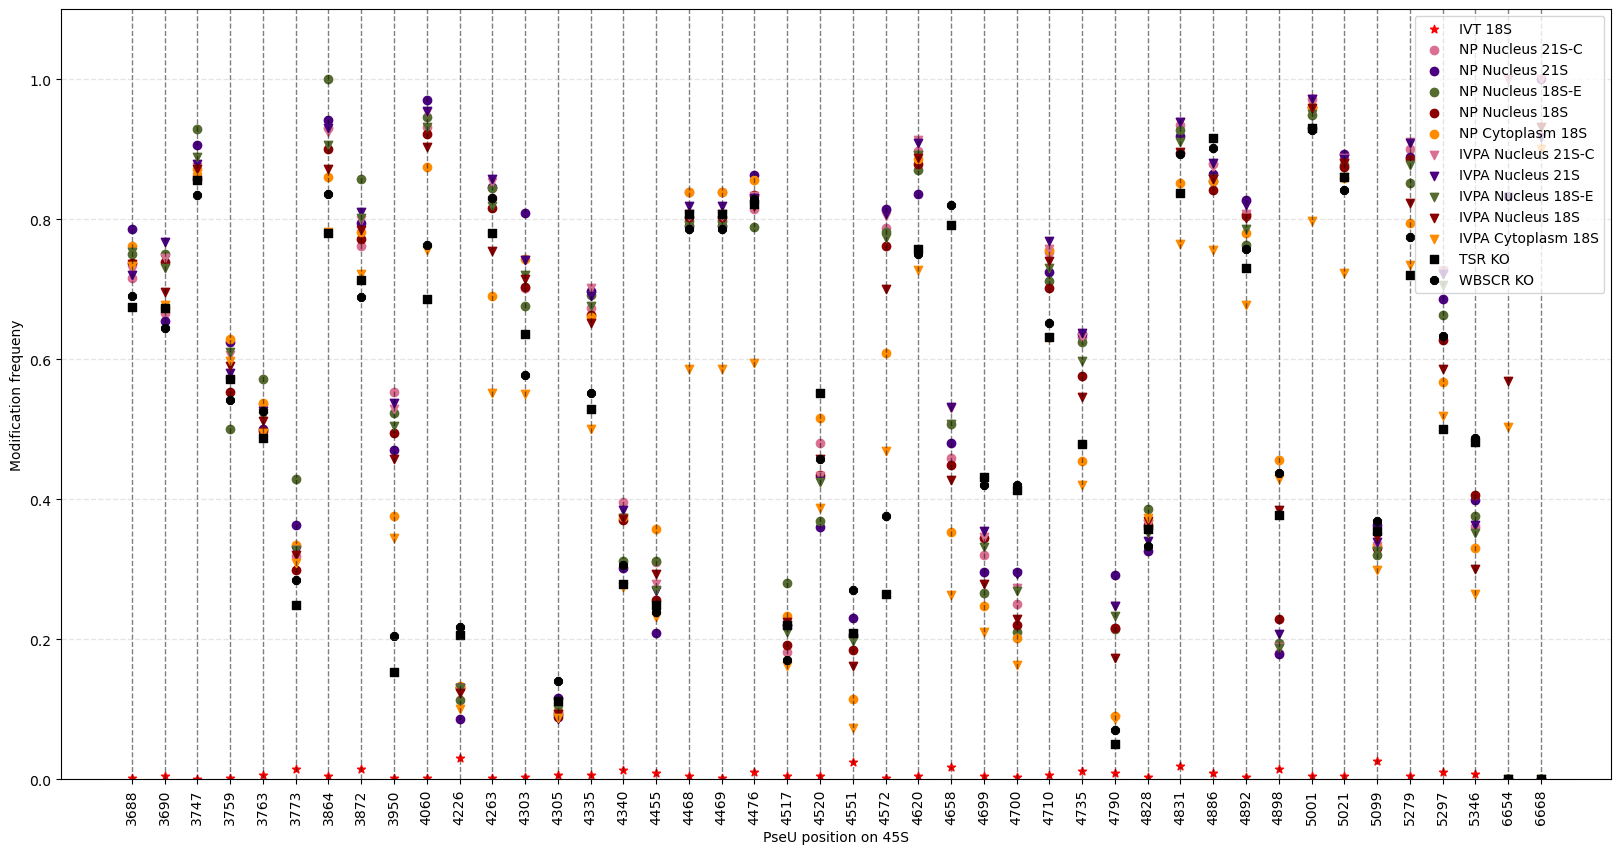

In [5]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
plt.xticks(rotation = 90)

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/IVT_18S/filtered_pod5/filtered_pod5_basecalled.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/IVT_18S/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="red",
                   markerstyle = "*",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVT_18S",
                   fig = fig,
                   ax = ax
                   )


view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="21S-C",
                   color="palevioletred",
                   markerstyle = "o",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Nucleus_21S-C",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="21S",
                   color="indigo",
                   markerstyle = "o",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Nucleus_21S",
                   fig = fig,
                   ax = ax
                   )


view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S-E",
                   color="darkolivegreen",
                   markerstyle = "o",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Nucleus_18S-E",
                   fig = fig,
                   ax = ax
                   )



view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="darkred",
                   markerstyle = "o",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Nucleus_18S",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Cyt/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Cyt/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="darkorange",
                   markerstyle = "o",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Cytoplasm_18S",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="21S-C",
                   color="palevioletred",
                   markerstyle = "v",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Nucleus_21S-C",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="21S",
                   color="indigo",
                   markerstyle = "v",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Nucleus_21S",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S-E",
                   color="darkolivegreen",
                   markerstyle = "v",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Nucleus_18S-E",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="darkred",
                   markerstyle = "v",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Nucleus_18S",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Cyt/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Cyt/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="darkorange",
                   markerstyle = "v",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Cytoplasm_18S",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/TSR_KO/filtered_pod5/filtered_pod5_rebasecalled.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/TSR_KO/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="black",
                   markerstyle = "s",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "TSR_KO",
                   fig = fig,
                   ax = ax
                   )


view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/WBSCR_KO/filtered_pod5/filtered_pod5_rebasecalled.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/WBSCR_KO/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="black",
                   markerstyle = "8",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "WBSCR_KO",
                   fig = fig,
                   ax = ax
                   )

view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/DIMT1L_KO/filtered_pod5/filtered_pod5_rebasecalled.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/DIMT1L_KO/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="black",
                   markerstyle = "X",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "DIMT1L_KO",
                   fig = fig,
                   ax = ax
                   )

ax.legend(loc='upper right')
ax.set_xlabel("PseU position on 45S")
ax.set_ylabel("Modification frequeny")
ax.set_ylim(0,1.1)

for tick in ax.get_xticks():
    ax.axvline(tick, color='black', linestyle='--', linewidth=1, alpha=.5)

for tick in ax.get_yticks():
    ax.axhline(tick, color='gray', linestyle='--', linewidth=1, alpha=.2)


In [6]:
fig.savefig("scatterplot_relative_modification_ratios_18S.svg", format='svg', dpi=1200)

In [ ]:
view_modification_per_fragment(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Cyt/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   fragment_df_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Cyt/template_based_analysis/template_fragment_df.csv",
                   fragment_to_analyse="18S",
                   color="darkorange",
                   linestyle = "--",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Cytoplasm_18S",
                   fig = fig,
                   ax = ax
                   )

In [ ]:
view_modifications(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Cyt/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   IVT_path = "~/Synology/Data_nano_ribolyzer/directRNA_004/IVT_18S/filtered_pod5/filtered_pod5_basecalled.bam",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Cytoplasm"
                   )

In [ ]:
view_modifications(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_NP_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   IVT_path = "~/Synology/Data_nano_ribolyzer/directRNA_004/IVT_18S/filtered_pod5/filtered_pod5_basecalled.bam",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "NP_Nuc"
                   )

In [ ]:
view_modifications(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Nuc/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   IVT_path = "~/Synology/Data_nano_ribolyzer/directRNA_004/IVT_18S/filtered_pod5/filtered_pod5_basecalled.bam",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Nuc"
                   )

In [ ]:
view_modifications(bamfile_path="~/Synology/Data_nano_ribolyzer/directRNA_004/20231114_RNA004_IVPA_Cyt/filtered_pod5/filtered_pod5_rebasecalled_psU_m6A_aligned.bam",
                   IVT_path = "~/Synology/Data_nano_ribolyzer/directRNA_004/IVT_18S/filtered_pod5/filtered_pod5_basecalled.bam",
                   reference_path="~/wf-nanoribolyzer/references/RNA45SN1.fasta",
                   literature_mod_df_path="~/wf-nanoribolyzer/references/rRNA_modifications_conv.bed",
                   condition = "IVPA_Cyt"
                   )